In [1]:
import pandas as pd
import requests
import os
import time
import pprint

from tqdm.auto import tqdm  # for notebooks

tqdm.pandas()

import warnings

from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

dev = True

In [2]:
games = pd.DataFrame()

file_path = "replays.parquet"
if os.path.exists(file_path):
    disk = pd.read_parquet(file_path)
    if "id" in disk.columns:
        disk = disk.set_index("id")
    games = disk


n_api_new_rows = limit = 20
page = 0
while n_api_new_rows == limit and limit > 0 and page <= 3:
    page += 1
    apiUrl = f"https://api.bar-rts.com/replays?limit={limit}&preset=team&hasBots=true&page={page}"
    if page > 1:
        time.sleep(1.2)
    json = requests.get(apiUrl, headers={"User-Agent": "tetrisface"}).json()

    data = json["data"]

    api = pd.DataFrame.from_records(data).set_index("id")

    api_new_indices = api.index.difference(games.index)
    n_api_new_rows = len(api_new_indices)
    n_before_games = len(games)
    games = pd.concat(
        [games, api.loc[api_new_indices]],
        verify_integrity=True,
        axis=0,
    )
    games.startTime = pd.to_datetime(games.startTime)
    games.durationMs = pd.to_numeric(games.durationMs, downcast="integer")
    games.drop(["Map"], axis=1, errors="ignore", inplace=True)
    print(f"games {n_before_games} + {n_api_new_rows} = {len(games)}")
games.to_parquet(file_path)

games 15729 + 12 = 15741


In [3]:
pd.options.mode.copy_on_write = True


def is_raptors(row):
    for team in row:
        for ai in team["AIs"]:
            if ai["shortName"] == "RaptorsAI":
                return True
    return False


def is_draw(row):
    results = []
    for team in row:
        results.append(team["winningTeam"])
    return len(team) <= 1 or all(
        x == results[0] for x in [team["winningTeam"] for team in row]
    )


def winners(row):
    _winners = []
    for team in row:
        if team["winningTeam"] is True:
            if len(team["Players"]) > 0:
                _winners.extend([player["name"] for player in team["Players"]])
            elif len(team["AIs"]) > 0:
                _winners.extend([ai["shortName"] for ai in team["AIs"]])
    return _winners


def players(row):
    _players = []
    for team in row:
        _players.extend([player["name"] for player in team["Players"]])
    return _players


games["raptors"] = games["AllyTeams"].apply(is_raptors)
games["draw"] = games["AllyTeams"].apply(is_draw)
games["winners"] = games["AllyTeams"].apply(winners)
games["players"] = games["AllyTeams"].apply(players)

In [4]:
numerical_columns = [
    "ai_incomemultiplier",
    "air_rework",
    "allowpausegameplay",
    "allowuserwidgets",
    "april1",
    "april1extra",
    "assistdronesair",
    "assistdronesbuildpowermultiplier",
    "assistdronescount",
    "capturebonus",
    "captureradius",
    "capturetime",
    "commanderbuildersbuildpower",
    "commanderbuildersrange",
    "coop",
    "critters",
    "debugcommands",
    "decapspeed",
    "defaultdecals",
    "disable_fogofwar",
    "disablemapdamage",
    "dominationscore",
    "dominationscoretime",
    "easter_egg_hunt",
    "easteregghunt",
    "emprework",
    "energyperpoint",
    "experimentalextraunits",
    "experimentalimprovedtransports",
    "experimentallegionfaction",
    "experimentalmassoverride",
    "experimentalnoaircollisions",
    "experimentalrebalancet2energy",
    "experimentalrebalancet2labs",
    "experimentalrebalancet2metalextractors",
    "experimentalrebalancewreckstandarization",
    "experimentalreversegear",
    "experimentalxpgain",
    "faction_limiter",
    "ffa_wreckage",
    "fixedallies",
    "lategame_rebalance",
    "limitscore",
    "map_atmosphere",
    "map_waterislava",
    "map_waterlevel",
    "maxunits",
    "metalperpoint",
    "multiplier_builddistance",
    "multiplier_buildpower",
    "multiplier_buildtimecost",
    "multiplier_energyconversion",
    "multiplier_energycost",
    "multiplier_energyproduction",
    "multiplier_losrange",
    "multiplier_maxdamage",
    "multiplier_maxvelocity",
    "multiplier_metalcost",
    "multiplier_metalextraction",
    "multiplier_radarrange",
    "multiplier_resourceincome",
    "multiplier_shieldpower",
    "multiplier_turnrate",
    "multiplier_weapondamage",
    "multiplier_weaponrange",
    "norush",
    "norushtimer",
    "numberofcontrolpoints",
    "proposed_unit_reworks",
    "ranked_game",
    "raptor_endless",
    "raptor_firstwavesboost",
    "raptor_graceperiodmult",
    "raptor_queentimemult",
    "raptor_spawncountmult",
    "raptor_spawntimemult",
    "releasecandidates",
    "ruins_civilian_disable",
    "ruins_only_t1",
    "scav_bosstimemult",
    "scav_endless",
    "scav_graceperiodmult",
    "scav_spawncountmult",
    "scav_spawntimemult",
    "scoremode_chess_adduptime",
    "scoremode_chess_spawnsperphase",
    "scoremode_chess_unbalanced",
    "scoremode_chess",
    "shareddynamicalliancevictory",
    "skyshift",
    "startenergy",
    "startenergystorage",
    "startmetal",
    "startmetalstorage",
    "starttime",
    "teamffa_start_boxes_shuffle",
    "tugofwarmodifier",
    "unified_maxslope",
    "unit_restrictions_noair",
    "unit_restrictions_noconverters",
    "unit_restrictions_noendgamelrpc",
    "unit_restrictions_noextractors",
    "unit_restrictions_nolrpc",
    "unit_restrictions_nonukes",
    "unit_restrictions_notacnukes",
    "unit_restrictions_notech2",
    "unit_restrictions_notech3",
    "usemapconfig",
    "usemexconfig",
]
string_columns = [
    "assistdronesenabled",
    "commanderbuildersenabled",
    "deathmode",
    "experimentalshields",
    "experimentalstandardgravity",
    "lootboxes_density",
    "lootboxes",
    "map_tidal",
    "raptor_difficulty",
    "raptor_raptorstart",
    "ruins_density",
    "ruins",
    "scav_difficulty",
    "scav_scavstart",
    "scoremode",
    "teamcolors_anonymous_mode",
    "teamcolors_icon_dev_mode",
    "transportenemy",
    "tweakdefs",
    "tweakdefs1",
    "tweakdefs2",
    "tweakdefs3",
    "tweakdefs4",
    "tweakdefs5",
    "tweakdefs6",
    "tweakdefs7",
    "tweakdefs8",
    "tweakdefs9",
    "tweakunits",
    "tweakunits1",
    "tweakunits2",
    "tweakunits3",
    "tweakunits4",
    "tweakunits5",
    "tweakunits6",
    "tweakunits7",
    "tweakunits8",
    "tweakunits9",
]


def cast_frame(_df):

    for col in string_columns:
        _df[string_columns] = _df[string_columns].fillna("")

    _df = _df.astype({col: str for col in string_columns}, errors="raise")

    for col in numerical_columns:
        _df[numerical_columns] = _df[numerical_columns].fillna(0)

    for col in numerical_columns:
        _df[col] = pd.to_numeric(
            _df[col],
            downcast="integer",
        )

    return _df

In [23]:
raptor_games = games[
    games["raptors"]
    # & ~df_root_expanded["draw"]
]  # draws might be good to exclude

raptor_games["fetch_success"] = None


def api_replay_detail(row):
    time.sleep(1.2)
    if row is not None and row.name is not None:
        url = f"https://api.bar-rts.com/replays/{row.name}"
        response = requests.get(url, headers={"User-Agent": "tetrisface"})
        if response.status_code == 200:
            response_json = response.json()
            replay_details = response_json.get("gameSettings")
            replay_details["awards"] = response_json.get("awards")
            replay_details["AllyTeams"] = response_json.get("AllyTeams")
            for key, value in replay_details.items():
                # Add new column to DataFrame if the column doesn't exist
                if key not in raptor_games.columns:
                    raptor_games[key] = None
                # Update DataFrame with fetched data
                row[key] = value
            row["fetch_success"] = True
            return row
    print(f"Failed to fetch data from {url}")
    row["fetch_success"] = False
    return row


raptor_games.durationMs = raptor_games.durationMs.astype("int64")

# load in disk
game_detail_path = "replays_gamesettings.parquet"
if os.path.exists(game_detail_path):
    disk = pd.read_parquet(game_detail_path)
    raptor_games.loc[disk.index, disk.columns] = disk


isnull = raptor_games[
    raptor_games.fetch_success.isnull() | (raptor_games.fetch_success == False)
]
to_fetch = isnull.head(100)
print(f"fetching {len(to_fetch)} of {len(isnull)} missing games")

# fetch new
df_raptors_api = to_fetch.progress_apply(
    api_replay_detail,
    axis=1,
)
raptor_games.loc[df_raptors_api.index, df_raptors_api.columns] = cast_frame(
    df_raptors_api
)

if len(raptor_games.loc[raptor_games.fetch_success == False]) > 0:
    print(f"failed to fetch {len(raptor_games[~raptor_games.fetch_success])} games")

raptor_games = cast_frame(raptor_games)

fetching 0 of 0 missing games


0it [00:00, ?it/s]

In [6]:
raptor_games.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2920 entries, 0cb40a66f0eb04a7025bc929bf299f35 to ccff1266a2b223a5f059c9fc95a44d78
Data columns (total 157 columns):
 #    Column                                    Dtype              
---   ------                                    -----              
 0    startTime                                 datetime64[ns, UTC]
 1    durationMs                                int64              
 2    AllyTeams                                 object             
 3    raptors                                   bool               
 4    draw                                      bool               
 5    winners                                   object             
 6    players                                   object             
 7    fetch_success                             object             
 8    Map                                       object             
 9    transportenemy                            object             
 10   tweakunits3     

In [7]:
# refetch all game details
# raptor_games["fetch_success"] = False
# store
raptor_games[raptor_games["fetch_success"].notnull()].to_parquet(game_detail_path)

In [8]:
from gamesettings import hp_multiplier, main, coms, meganuke_149, wind_restrict_149, gamesettings

raptor_games['raptor_win'] = raptor_games.apply(lambda row: 'RaptorsAI' in row['winners'] and (row['draw'] == False), axis=1)
raptor_games['player_win'] = raptor_games.apply(lambda row: ('RaptorsAI' not in row['winners'])
                                                and (len(row['winners']) > 0)
                                                and (row['draw'] == False), axis=1)



raptor_games["nuttyb_main"] = raptor_games.apply(
    lambda row: all(
        [
            tweak["value"] == row[tweak["location"]]
            for tweak in main
            if tweak["version"] == "1.48"
        ]
    )
    or all(
        [
            tweak["value"] == row[tweak["location"]]
            for tweak in main
            if tweak["version"] == "1.49"
        ]
    ),
    axis=1,
)


def nuttyb_difficulty(row):
    for _def in hp_multiplier:
        if 'values' in _def:
            if row[_def["location"]] in _def["values"]:
                return _def["name"]
        else:
            if row[_def["location"]] == _def["value"]:
                return _def["name"]
    return None


raptor_games["nuttyb_hp"] = raptor_games.apply(nuttyb_difficulty, axis=1)


possible_tweaks = ['tweakunits', 'tweakdefs'] +[f'tweakunits{i}' for i in range(1, 10)] + [f'tweakdefs{i}' for i in range(1, 10)]
all_allowed_tweaks = []
for setting_dict in [setting_dict for setting_dict in [*main, *hp_multiplier, *coms, meganuke_149, wind_restrict_149]]:
    if 'values' in setting_dict:
        all_allowed_tweaks.extend(setting_dict['values'])
    else:
        all_allowed_tweaks.append(setting_dict['value'])

def is_nuttyb_tweaks_exclusive(row):
    if row["nuttyb_main"] == True \
        and row["nuttyb_hp"] is not None and len(row["nuttyb_hp"]) > 0 \
        and row[possible_tweaks][row[possible_tweaks].astype(bool)].isin(all_allowed_tweaks).all():
        return True
    return False

raptor_games["nuttyb_tweaks_exclusive"] = raptor_games.apply(is_nuttyb_tweaks_exclusive, axis=1)


raptor_games['raptor_raptorstart'] = pd.Categorical(
    raptor_games['raptor_raptorstart'],
    ['alwaysbox', 'initialbox', 'avoid'],
    ordered=True
)
higher_harder = {
    'raptor_spawncountmult',
    'raptor_firstwavesboost',
    # 'raptor_raptorstart', # uncertain
}
lower_harder = {
    'startmetal',
    'startenergy',
    'startmetalstorage',
    'startenergystorage',
    'multiplier_builddistance',
    'multiplier_shieldpower',
    'multiplier_buildpower',
    'commanderbuildersrange',
    'commanderbuildersbuildpower',
    'raptor_queentimemult', # probably harder
    'raptor_spawntimemult',
}

def nuttyb_mode(row):
    for mode_name, settings in gamesettings.items():
        match = False
        # print(f'checking mode {mode_name}, {pprint.pformat(settings)}')
        for setting, value in settings.items():
            if row[setting] == value or (setting in higher_harder and row[setting] >= value) or (setting == 'raptor_raptorstart' and row[setting] == 'avoid') or (setting in lower_harder and row[setting] <= value):
                # print(f'value matching mode {mode_name} {setting} {row[setting]} ~= {value} higher harder {setting in higher_harder} lower harder {setting in lower_harder}')
                match = True
            elif row[setting] != value:
                # print(f'value not matching mode {mode_name} {setting} {row[setting]} != {value}')
                match = False
                break
            else:
                raise Exception(f"unhandled setting {setting} value {value}")
        if match:
            return mode_name
    return ''

# print(f'found mode { nuttyb_mode(raptor_games.loc['5bd8116605ce75f19618af055dd363a4']) }')
# print(f'found mode { nuttyb_mode(raptor_games.loc['46990c66b597eee2b2d25216620d652b']) }')
raptor_games["Gamesettings Mode"] = pd.Categorical(
    raptor_games.apply(nuttyb_mode, axis=1),
    [
        "Gauntlet",
        "0 grace zerg",
        "Zerg",
        "0 grace",
        "Rush",
        "Gauntlet 1.48",
        "Zerg 1.48",
        "Rush 1.48",
        "Max spawn, 1k res",
        "Max spawn, 5k res",
        "Max spawn, 10k res",
        "Max spawn, 1k res, extraunits",
        "Max spawn, 5k res, extraunits",
        "Max spawn, 10k res, extraunits",
        '',
    ],
    ordered=True
)


def format_raptor_diff(string):
    return string.replace('very','very ').title()

def raptor_diff(row):
    if row["nuttyb_tweaks_exclusive"] and row['Gamesettings Mode'] in {"Gauntlet", "0 grace zerg", "Zerg", "0 grace", "Rush", "Gauntlet 1.48", "Zerg 1.48", "Rush 1.48"}:
        return f"NuttyB Default {row['nuttyb_hp']}"
    elif row["nuttyb_main"]:
        if row["nuttyb_hp"]:
            return f"NuttyB Main & HP {row["nuttyb_hp"]}"
        else:
            return f"NuttyB Main & {format_raptor_diff(row["raptor_difficulty"])}"
    elif row["nuttyb_hp"]:
        return f"NuttyB HP {row["nuttyb_hp"]}"
    else:
        return f"{format_raptor_diff(row["raptor_difficulty"])}"
    print('no diff found for', row[["nuttyb_main", "nuttyb_hp", "raptor_difficulty", "nuttyb_tweaks_exclusive"]])
    return ''

raptor_games["Difficulty"] = pd.Categorical(
    raptor_games.apply(
        raptor_diff,
        axis=1),
        [
            "NuttyB Default Epicest",
            "NuttyB Default Epicer+",
            "NuttyB Default Epic++",
            "NuttyB Default Epic+",
            "NuttyB Default Epic",
            "NuttyB Main & HP Epicest",
            "NuttyB Main & HP Epicer+",
            "NuttyB Main & HP Epic++",
            "NuttyB Main & HP Epic+",
            "NuttyB Main & HP Epic",
            "NuttyB HP Epicest",
            "NuttyB HP Epicer+",
            "NuttyB HP Epic++",
            "NuttyB HP Epic+",
            "NuttyB HP Epic",
            "NuttyB Main & Epic",
            "NuttyB Main & Very Hard",
            "NuttyB Main & Hard",
            "NuttyB Main & Normal",
            "NuttyB Main & Easy",
            "NuttyB Main & Very Easy",
            "Epic",
            "Very Hard",
            "Hard",
            "Normal",
            "Easy",
            "Very Easy",
            '',
        ],
        ordered=True,
)

raptor_games["has_mode"] = raptor_games["Gamesettings Mode"] != ''

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    try:
        na_games = raptor_games[raptor_games["Difficulty"].isna() & raptor_games["fetch_success"] == True]
        na_games_related = na_games[['nuttyb_main', "nuttyb_hp",'raptor_difficulty', 'Difficulty', 'Gamesettings Mode']]
        assert (
            len(na_games) == 0
        ), f'missing difficulties for {len(na_games)} {na_games_related}'
    except AssertionError as e:
        print(e)
        print(na_games_related)

In [16]:
def awards(row):
    player_team_id = None
    for ally_team in row["AllyTeams"]:
        if len(ally_team["Players"]) > 0:
            for player in ally_team["Players"]:
                if player["name"] == row["player"] and "teamId" in player:
                    player_team_id = player["teamId"]
                    break

    if player_team_id is None or not row["awards"]:
        return pd.Series([0, 0])

    damage = 0
    eco = 0
    try:
        if player_team_id == row["awards"]["fightingUnitsDestroyed"][0]["teamId"]:
            damage = 1
    except KeyError:
        damage = 0

    try:
        if player_team_id == row["awards"]["mostResourcesProduced"]["teamId"]:
            eco = 1
    except KeyError:
        eco = 0

    return pd.Series([damage, eco])


def links_cell(url_pairs):
    cell = "=" + f'ifna(hyperlink("{url_pairs[0][0]}";"[{url_pairs[0][1]+1}]")'
    if len(url_pairs) > 1:
        cell += (
            '; "'
            + ", ".join([f"[{index+1}] {url}" for url, index in url_pairs[1:]])
            + '"'
        )
    return cell + ")"


def grouped(_df):
    all_groups = pd.DataFrame()
    for (group_diff, group_mode), group_df in _df.groupby(
        ["Difficulty", "Gamesettings Mode"],
        observed=True,
        sort=True,
        dropna=False,
    ):
        group_df["_player_group_bypass"] = group_df["player"]
        group_df["_player_lower_case"] = group_df["player"].str.lower()
        group_df["game_player_n_awards"] = (
            group_df["award_damage"] + group_df["award_eco"]
        )
        group_df["Replays"] = group_df.index

        group_players = (
            group_df.groupby(["player"])
            .agg(
                {
                    "player": "count",
                    "game_player_n_awards": "sum",
                    "award_damage": "sum",
                    "award_eco": "sum",
                    "Replays": lambda replay_ids: links_cell(
                        [
                            (f"https://bar-rts.com/replays/{replay_id}", index)
                            for index, replay_id in list(
                                reversed(list(enumerate(replay_ids)))
                            )
                        ]
                    ),
                    "_player_group_bypass": lambda x: x.iloc[0],
                    "_player_lower_case": lambda x: x.iloc[0],
                }
            )
            .rename(
                columns={
                    "player": "_victories_count",
                    "_player_group_bypass": "Player",
                    "Replays": "Victories",
                    "award_damage": "🏆DMG",
                    "award_eco": "🏆ECO",
                },
            )
            .reset_index(drop=True)
            .sort_values(
                [
                    "_victories_count",
                    "game_player_n_awards",
                    "🏆DMG",
                    "_player_lower_case",
                ],
                ascending=[
                    False,
                    False,
                    False,
                    True,
                ],
            )
            .reset_index(drop=True)[["Player", "Victories", "🏆DMG", "🏆ECO"]]
        )
        pd.set_option(
            "display.max_columns",
            None,
            "display.max_rows",
            None,
        )
        group_players.columns = pd.MultiIndex.from_tuples(
            [
                (
                    group_diff
                    + (
                        " - " + group_mode
                        if group_mode and not pd.isna(group_mode)
                        else ""
                    ),
                    second_level_columns,
                )
                for second_level_columns in group_players.columns
            ]
        )

        all_groups = (
            pd.concat(
                [
                    all_groups,
                    group_players,
                ],
                axis=1,
            )
            .fillna("")
            .replace(0, "")
        )

    return all_groups


import datetime
import gspread

gc = gspread.service_account()

# spreadsheet = gc.open_by_key("1oI7EJIUiwLLXDMBgky2BN8gM6eaQRb9poWGiP2IKot0")
spreadsheet = gc.open_by_key("1w8Ng9GGUo6DU0rBFRYRnC_JxK8nHTSSjf1Nbq1e-3bc")  # dev


def update_sheet(_df, sheet_name_postfix):
    sheet_name = datetime.date.today().strftime("%Y-%m") + sheet_name_postfix
    new_sheet = False
    try:
        worksheet = spreadsheet.worksheet(sheet_name)
        worksheet.clear()
    except gspread.exceptions.WorksheetNotFound:
        worksheet = spreadsheet.add_worksheet(
            title=sheet_name, rows=len(_df), cols=len(_df.columns), index=0
        )
        new_sheet = True

    first_header, second_header = zip(*_df.columns)
    values = (
        [[x if index % 4 == 0 else "" for index, x in enumerate(first_header)]]
        + [second_header]
        + _df.values.tolist()
    )
    worksheet.update(
        values=values,
        value_input_option=gspread.utils.ValueInputOption.user_entered,
    )

    unicode_char_columns = [index for index, x in enumerate(second_header) if "🏆" in x]
    player_columns = [index for index, x in enumerate(second_header) if "Player" in x]

    sheet_id = worksheet._properties["sheetId"]
    body = {
        "requests": [
            {
                "repeatCell": {
                    "range": {
                        "sheetId": sheet_id,
                    },
                    "cell": {
                        "userEnteredFormat": {
                            "textFormat": {
                                "fontSize": 11,
                            },
                            "hyperlinkDisplayType": "LINKED",
                        }
                    },
                    "fields": "userEnteredFormat",
                }
            },
            {
                "autoResizeDimensions": {
                    "dimensions": {
                        "sheetId": sheet_id,
                        "dimension": "COLUMNS",
                    }
                }
            },
            {
                "repeatCell": {
                    "range": {
                        "sheetId": sheet_id,
                    },
                    "cell": {
                        "userEnteredFormat": {
                            "textFormat": {
                                "fontSize": 10,
                            },
                            "hyperlinkDisplayType": "LINKED",
                        }
                    },
                    "fields": "userEnteredFormat",
                }
            },
            {
                "updateSheetProperties": {
                    "properties": {
                        "sheetId": sheet_id,
                        "gridProperties": {"frozenRowCount": 2},
                    },
                    "fields": "gridProperties(frozenRowCount)",
                }
            },
        ]
        + [
            {
                "updateDimensionProperties": {
                    "range": {
                        "sheetId": sheet_id,
                        "dimension": "COLUMNS",
                        "startIndex": index,
                        "endIndex": index + 1,
                    },
                    "properties": {"pixelSize": 52},
                    "fields": "pixelSize",
                }
            }
            for index in unicode_char_columns
        ]
        + [
            {
                "repeatCell": {
                    "cell": {
                        "userEnteredFormat": {
                            "horizontalAlignment": "LEFT",
                        }
                    },
                    "range": {
                        "sheetId": sheet_id,
                        "startColumnIndex": index,
                        "endColumnIndex": index + 1,
                    },
                    "fields": "userEnteredFormat(horizontalAlignment)",
                }
            }
            for index in player_columns
        ]
    }
    if new_sheet:
        body["requests"].append(
            {
                "addBanding": {
                    "bandedRange": {
                        "bandedRangeId": sheet_id,
                        "range": {
                            "sheetId": sheet_id,
                            "startRowIndex": 2,
                        },
                        "rowProperties": {
                            "firstBandColorStyle": {
                                "rgbColor": {
                                    "red": 243 / 255,
                                    "green": 243 / 255,
                                    "blue": 243 / 255,
                                },
                            },
                            "secondBandColorStyle": {"themeColor": "BACKGROUND"},
                        },
                    },
                },
            }
        )
    res = spreadsheet.batch_update(body)


raptor_players = raptor_games.explode("players")
raptor_players.rename(columns={"players": "player"}, inplace=True)

raptor_players["won"] = raptor_players.apply(
    lambda row: row.player in row.winners, axis=1
)

raptor_players[["award_damage", "award_eco"]] = raptor_players.apply(awards, axis=1)

winners = raptor_players[raptor_players["player_win"]]
nuttyb_tweaks_winners = raptor_players[
    raptor_players["nuttyb_tweaks_exclusive"] == True
]
nuttyb_tweaks_winners_grouped = grouped(nuttyb_tweaks_winners)

regular_winners = winners[
    winners["Difficulty"].isin(
        ["Epic", "Very Hard", "Hard", "Normal", "Easy", "Very Easy"]
    )
]
regular_winners_grouped = grouped(regular_winners)

all_winners_grouped = grouped(winners)

update_sheet(all_winners_grouped, " All")
update_sheet(regular_winners_grouped, " Regular")
update_sheet(nuttyb_tweaks_winners_grouped, " NuttyB")

with pd.option_context(
    "display.max_rows",
    None,
    "display.max_columns",
    None,
    "display.float_format",
    "{:.0f}".format,
):
    display(regular_winners.head(1))
    # display(all_winners.head(20))
    # display(nuttyb_tweaks_winners.head(20))

,startTime,durationMs,AllyTeams,raptors,draw,winners,player,fetch_success,Map,transportenemy,tweakunits3,experimentalextraunits,maxunits,unit_restrictions_noair,multiplier_maxdamage,raptor_firstwavesboost,raptor_raptorstart,assistdronescount,disablemapdamage,scav_spawntimemult,multiplier_metalcost,unit_restrictions_noendgamelrpc,tweakunits,debugcommands,allowpausegameplay,multiplier_energyproduction,unit_restrictions_nonukes,scav_spawncountmult,multiplier_energycost,multiplier_builddistance,tweakdefs3,assistdronesair,unified_maxslope,startenergy,april1extra,tweakdefs2,ruins_civilian_disable,startmetal,teamffa_start_boxes_shuffle,experimentalnoaircollisions,raptor_spawncountmult,lootboxes,ffa_wreckage,raptor_queentimemult,multiplier_weaponrange,multiplier_maxvelocity,scav_graceperiodmult,tweakunits9,ruins_density,assistdronesenabled,experimentalstandardgravity,tweakdefs7,map_waterlevel,scav_difficulty,unit_restrictions_notech3,unit_restrictions_notech2,multiplier_shieldpower,april1,tweakdefs5,commanderbuildersenabled,tweakdefs,unit_restrictions_noconverters,emprework,raptor_graceperiodmult,tweakdefs9,tweakunits4,experimentalxpgain,multiplier_buildpower,teamcolors_icon_dev_mode,scav_scavstart,assistdronesbuildpowermultiplier,ruins,ruins_only_t1,proposed_unit_reworks,multiplier_buildtimecost,multiplier_resourceincome,tweakdefs8,map_tidal,unit_restrictions_nolrpc,unit_restrictions_noextractors,multiplier_turnrate,tweakdefs1,norushtimer,raptor_spawntimemult,skyshift,tweakunits2,tweakunits8,lootboxes_density,multiplier_energyconversion,allowuserwidgets,shareddynamicalliancevictory,tweakunits5,unit_restrictions_notacnukes,experimentallegionfaction,experimentalshields,startenergystorage,startmetalstorage,map_atmosphere,lategame_rebalance,faction_limiter,multiplier_metalextraction,tweakunits6,multiplier_losrange,easteregghunt,scav_endless,disable_fogofwar,tweakdefs4,tweakunits1,ranked_game,fixedallies,coop,scav_bosstimemult,critters,tweakunits7,commanderbuildersrange,defaultdecals,multiplier_weapondamage,raptor_difficulty,multiplier_radarrange,map_waterislava,commanderbuildersbuildpower,releasecandidates,raptor_endless,tweakdefs6,teamcolors_anonymous_mode,ai_incomemultiplier,deathmode,air_rework,experimentalrebalancewreckstandarization,experimentalrebalancet2energy,experimentalrebalancet2metalextractors,experimentalmassoverride,experimentalimprovedtransports,experimentalrebalancet2labs,metalperpoint,captureradius,decapspeed,limitscore,scoremode_chess_unbalanced,usemexconfig,usemapconfig,tugofwarmodifier,capturetime,scoremode_chess_adduptime,dominationscoretime,capturebonus,starttime,scoremode_chess,dominationscore,energyperpoint,scoremode,numberofcontrolpoints,scoremode_chess_spawnsperphase,norush,experimentalreversegear,easter_egg_hunt,awards,raptor_win,player_win,nuttyb_main,nuttyb_hp,nuttyb_tweaks_exclusive,Gamesettings Mode,Difficulty,has_mode,won,award_damage,award_eco
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69670a66b8e5e85a8c2aa4783defde52,2024-04-01 07:51:05+00:00,1844433,"[{'AIs': [], 'Players': [{'allyTeamId': 151761...",True,False,"[rooks[vegan], ThatOneCamo, [zip], IBBACK, r3f...",rooks[vegan],True,"{'fileName': 'full_metal_plate_1.7', 'scriptNa...",notcoms,,1,2000,0,1,1,initialbox,10,0,1,1,0,,0,1,2,0,1,1,1,,1,0,5000,0,,0,5000,1,0,1,scav_only,0,1,1,1,1,,normal,enabled,mapgravity,,0,normal,0,0,1,1,,disabled,,0,1,3,,,1,1,disabled,initialbox,2,scav_only,1,1,1,2,,unchanged,0,0,1,,0,2,0,,,normal,2,1,0,,0,1,bounceeverything,10000,10000,1,0,0,2,,1,1,0,0,,,1,1,0,1,1,,1000,1,1,normal,1,0,400,1,0,,disabled,1,com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,"{'cow': {'teamId': -1.0}, 'econDestroyed': [{'...",False,True,False,None,False,,Normal,False,True,0,0


commanderbuildersbuildpower
400     975
1000    168
600      32
500      27
800      17
100       8
Name: count, dtype: int64


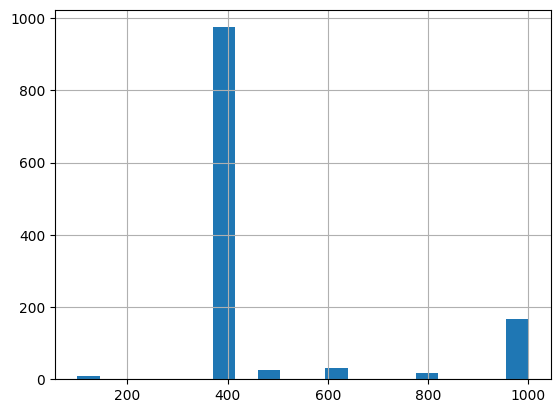

In [14]:
regular_winners.commanderbuildersbuildpower.hist(bins=20).plot()
print(regular_winners.commanderbuildersbuildpower.value_counts())

In [ ]:
# raptor_games.groupby("NuttyB Mode", observed=True).size()
# for a, b in default_nuttyb_winners.groupby(
#     ["Difficulty", "Gamesettings Mode"], observed=True, sort=True, dropna=False
# ):
#     print(a)
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(raptor_games.loc["aa441066266c75370bc7591ab0f84630"])

In [37]:
# print(f'nuttyb main {len(raptor_games[raptor_games["nuttyb_main"]])}')
# print(
#     f'nuttyb main + hp {len(raptor_games[raptor_games["nuttyb_main"] & raptor_games["nuttyb_hp"]])}'
# )
# print(
#     f'default nuttyb {len(raptor_games[raptor_games["default_nuttyb_tweaks"] & raptor_games["NuttyB Mode"].notna()])}'
# )
# default_wins = raptor_games[
#     (raptor_games["default_nuttyb_tweaks"] == True)
#     & (raptor_games["player_win"] == True)
#     & (raptor_games["NuttyB Mode"].notna())
# ]
# print(f"default nuttyb wins {len(default_wins)}")
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     display(
#         default_wins[["startTime", "Difficulty", "NuttyB Mode", "players", "winners"]]
#     )

In [38]:
import csv


# player_game_mask = raptor_games["players"].apply(lambda x: 'tetrisface' in x)
player_game_mask = False

total_unique = raptor_players.player.nunique()

print(
    f'{len(raptor_games[player_game_mask] if player_game_mask else raptor_games)} games and {total_unique} player names between {raptor_players["startTime"].min().date()} and {raptor_players["startTime"].max().date()}'
)
# raptor_players["Difficulty"] =
agg_total = raptor_players.groupby(["Difficulty"], observed=True).agg(
    {"player": "nunique"}
)
agg_won = (
    raptor_players[raptor_players["won"]]
    .groupby(["Difficulty"], observed=True)
    .agg({"player": "nunique"})
)
game_modes = agg_total.join(agg_won, lsuffix="s have tried", rsuffix="s have won")
game_modes["% have won"] = (
    game_modes["players have won"] / game_modes["players have tried"] * 100
)
game_modes["% tried of total"] = game_modes["players have tried"] / total_unique * 100
game_modes["% won of total"] = game_modes["players have won"] / total_unique * 100
game_modes.fillna(0, inplace=True)
game_modes["players have won"] = game_modes["players have won"].astype(int)
# game_modes.to_csv("game_modes_stats.csv", quoting=csv.QUOTE_ALL)
display(
    game_modes.style.format(
        {
            "% have won": "{:.0f}%",
            "% tried of total": "{:.0f}%",
            "% won of total": "{:.0f}%",
        }
    ).set_table_styles(
        [{"selector": ".row_heading", "props": [("text-align", "left")]}]
    )
)

2887 games and 3055 player names between 2024-03-10 and 2024-04-07


,players have tried,players have won,% have won,% tried of total,% won of total
Difficulty,,,,,
NuttyB Default Epicest,13,0,0%,0%,0%
NuttyB Default Epic++,25,16,64%,1%,1%
NuttyB Default Epic+,632,343,54%,21%,11%
NuttyB Default Epic,202,118,58%,7%,4%
NuttyB Main & HP Epicest,119,20,17%,4%,1%
NuttyB Main & HP Epicer+,130,30,23%,4%,1%
NuttyB Main & HP Epic++,300,158,53%,10%,5%
NuttyB Main & HP Epic+,702,269,38%,23%,9%
NuttyB Main & HP Epic,407,233,57%,13%,8%


In [39]:
from math import log2
from collections import Counter


def ID3_entropies(data_df):
    """
    https://gist.github.com/whitehaven/bbd408edca38de93637635b52d2bba89

    Takes pandas.DataFrame and returns a series with all non-index schemas' entropies calculated.

    It supports non-binary field types by calculating average entropy. Result series starts with the most productive decision level.
    """

    def entropy_for_field(field):
        entropy = 0
        field_entry_count = len(field)

        # get count of unique
        field_counter = Counter(field)

        # E( Si/S * E(pi*log2(pi)) )
        for trait, count in field_counter.items():
            p_T = count / field_entry_count
            p_F = (field_entry_count - count) / field_entry_count

            if p_T == 0 or p_F == 0:
                entropy = 0
                break
            # Si/S * E(pi*log2(pi))
            entropy += (
                count / field_entry_count * (-(p_T * log2(p_T)) - (p_F * log2(p_F)))
            )
        return entropy

    data_df_entropy = {}
    for field in data_df:
        entropy_this_field = entropy_for_field(data_df[field])
        data_df_entropy[field] = entropy_this_field

    data_df_entropy_se = pd.Series(data_df_entropy)
    data_df_entropy_se.sort_values(inplace=True, ascending=False)
    return data_df_entropy_se


df_entropy = ID3_entropies(
    raptor_games.loc[:, raptor_games.columns.isin(numerical_columns)]
).to_frame("entropy")

In [40]:
stats_nuttyb = raptor_games[
    (raptor_games["nuttyb_main"] == True) | raptor_games["nuttyb_hp"] == True
].loc[:, raptor_games.columns.isin(numerical_columns)]
stats_nuttyb_entropy = ID3_entropies(stats_nuttyb).to_frame("entropy")

entropy_joined = stats_nuttyb.agg(
    ["mean", "median", "min", "max", "std", "skew", "kurt"]
).T.join(stats_nuttyb_entropy, how="outer")
entropy_joined = entropy_joined[
    (entropy_joined["entropy"] > 0) & (entropy_joined["min"] != entropy_joined["max"])
]
with pd.option_context("display.max_rows", 500):
    display(
        entropy_joined.sort_values(by="entropy", ascending=False)
        .style.format(
            {
                "median": "{:.1f}",
                "min": "{:.1f}",
                "max": "{:.1f}",
                "mean": "{:.2f}",
                "std": "{:.2f}",
                "skew": "{:.2f}",
                "kurt": "{:.2f}",
                "entropy": "{:.2f}",
            }
        )
        .set_table_styles(
            [{"selector": ".row_heading", "props": [("text-align", "left")]}]
        )
    )

,mean,median,min,max,std,skew,kurt,entropy
experimentalrebalancewreckstandarization,0.61,1.0,0.0,1.0,0.49,-0.45,-1.80,0.97
norushtimer,1.65,0.0,0.0,5.0,2.35,0.73,-1.48,0.91
ranked_game,0.69,1.0,0.0,1.0,0.46,-0.81,-1.34,0.90
disablemapdamage,0.70,1.0,0.0,1.0,0.46,-0.88,-1.23,0.88
decapspeed,0.56,0.0,0.0,2.0,0.90,0.97,-1.06,0.86
scoremode_chess,0.28,0.0,0.0,1.0,0.45,0.97,-1.06,0.86
usemapconfig,0.28,0.0,0.0,1.0,0.45,0.97,-1.06,0.86
dominationscoretime,8.47,0.0,0.0,30.0,13.51,0.97,-1.06,0.86
numberofcontrolpoints,3.67,0.0,0.0,13.0,5.85,0.97,-1.06,0.86
limitscore,84.67,0.0,0.0,300.0,135.10,0.97,-1.06,0.86


In [41]:
# df_raptors = df_raptors.explode("players")
# df_raptors.rename(columns={"players": "player"}, inplace=True)
# df_raptors["won"] = df_raptors.apply(lambda row: row.player in row.winners, axis=1)

# df_raptors["week"] = pd.to_datetime(df_raptors["startTime"]).dt.month
# df = df_raptors.groupby(["player", "week"]).agg({"won": "mean", "id": "count"})
# df = df.rename(columns={"won": "winrate", "id": "replays"})

# df = df[df.replays > 4]

# rank_sum_column = "rank_sum"
# df[rank_sum_column] = (df.winrate.rank() * 0.1 + df.replays.rank() * 0.9) / len(df)
# df.sort_values(rank_sum_column, inplace=True, ascending=False)

# df[rank_sum_column] = round(df[rank_sum_column], 2).astype(str)

# df.winrate = df.winrate * 100

In [42]:
# pd.set_option("display.max_rows", 500)
# pd.options.display.float_format = "{:.0f}%".format

# for week, df_week in df.groupby("week"):
#     # df_week = df_week[df_week["replays"] > 4].reset_index()
#     df_week = df_week.reset_index()
#     df_week.index = np.arange(1, len(df_week) + 1)
#     print(df_week.head(20))
#     print()